# Running Pipelines using MIRI image data from MAST

## Table of Contents:
> * [Detector1 Pipeline](#detector1_pipeline)
> * [Resources and Documentation](#resources)
> * [Download Data from MAST](#download_from_mast)
> * [Run Pipeline with Default Configuration](#pipeline_with_defaults)
> * [About Configuration Files](#pipeline_configs)
> * [Run Pipeline with Configuration Files](#pipeline_with_cfgs)
> * [Run Pipeline with Parameters Set Programmatically](#pipeline_no_configs)
> * [Run Individual Steps with Configuration Files](#steps_with_config_files)
> * [Run Level 1, 2, 3, Pipelines in Succession](#pipelines_level_123)

***
<a id=detector1_pipeline></a>
##  Detector1 Pipeline

Stage 1 consists of detector-level corrections that are performed on a group-by-group basis, followed by ramp fitting. 

More information can be found at: https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_detector1.html#calwebb-detector1

> **Inputs**: The inputs to stage 1 processing will usually be level-1b raw files.

> **Outputs**: The output of stage 1 processing is a countrate image per exposure, or per integration for some modes.
    
### Level 1 pipeline:

**Calwebb Detector1**   (jwst.pipeline, calwebb_detector1, Detector1Pipeline)   (calwebb_detector1.cfg)

### Level 1 pipeline steps:

**Group Scale** (jwst.group_scale, group_scale_step, GroupScaleStep)   (group_scale.cfg)

**DQInit** (jwst.dq_init, dq_init_step, DQInitStep)    (dq_init.cfg)

**Saturation** (jwst.saturation, saturation_step, SaturationStep)    (saturation.cfg)

**IPC**   (jwst.ipc,  ipc_step,  IPCStep)    (ipc.cfg)

**Super Bias**   (jwst.superbias,  superbias_step,  SuperBiasStep)    (superbias.cfg)

**Refpix** (jwst.refpix,  refpix_step,  RefpixStep)    (refpix.cfg)

**RSCD**   (jwst.rscd,  rscd_step,  RSCD_Step)   (rscd.cfd)

**First Frame**  (jwst.firstframe, firstframe_step,  FirstFrameStep)   (firstframe.cfg)

**Last Frame**  (jwst.lastframe,  lastframe_step, LastFrameStep)   (lastframe.cfg)

**Linearity**  (jwst.linearity,  linearity_step, LinearityStep)   (linearity.cfg)

**Dark Current**  (jwst.dark_current,  dark_current_step,  DarkCurrentStep)   (dark_current.cfg)

**Peristence**  (jwst.persistence,  persistence_step, PersistenceStep)   (persistence.cfg)

**Jump**  (jwst.jump, jump_step,  JumpStep)  (jump_step.cfg)

**RampFit**   (jwst.ramp_fit,  ramp_fit_step,  RampFitStep)   (ramp_fit_step.cfg)

**Gain Scale**  (jwst.gain_scale,  gain_scale_step,  GainScaleStep)   (gain_scale_step.cfg)

(for more information on individual steps see: https://jwst-pipeline.readthedocs.io/en/latest/jwst/package_index.html)

***
<a id='resources'></a>
## Resources and Documentation

There are several different places to find information on installing and running the pipeline. This notebook will give a shortened description of the steps pulled from the detailed pipeline information pages, but to find more in-depth instructions use the links below. 

>1. JDox: https://jwst-docs.stsci.edu/display/JDAT/JWST+Data+Reduction+Pipeline
>2. Installation page: http://astroconda.readthedocs.io/en/latest/releases.html#pipeline-install
>3. Detailed pipeline information: https://jwst-pipeline.readthedocs.io/en/latest/jwst/introduction.html
>4. Help Desk (click on Pipeline Support): https://stsci.service-now.com/jwst?id=sc_category
>5. GitHub README installation instructions: https://github.com/spacetelescope/jwst/blob/master/README.md


If this is your first time trying to run the pipeline from a jupyter notebook, you need to install the jupyter notebook in your pipeline environment:
>1. In a new terminal, change the directory to your working directory, terminal command: cd [your working directory]
>2. Terminal command: source activate jwst_dev
(or whatever your environment name for the pipeline is)
>3. Terminal command: conda install jupyter
>4. Terminal command: jupyter notebook

**NOTE:** During your first run CRDS may download and cache reference files in $HOME/crds_cache.  On subsequent runs cached files will be used.

## Imports

In [1]:
import os

from astropy.io import fits
from urllib.request import urlretrieve
import matplotlib.pyplot as plt
%matplotlib inline

from jwst.pipeline import Detector1Pipeline
from jwst.pipeline import Image2Pipeline
from jwst.pipeline import Image3Pipeline
from jwst import datamodels
from jwst.pipeline.collect_pipeline_cfgs import collect_pipeline_cfgs

### Quick & Dirty Plots

In [2]:
def plot_image(obj, index=None):
    if isinstance(obj, str):
        data = fits.getdata(obj)
    else:
        data = obj.data
    image = data[index] if index is not None else data
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(1, 1, 1)
    im = ax.imshow(image, origin='lower') # , norm=norm)
    fig.colorbar(im)
    plt.show()

***
<a id="download_from_mast"></a>
## Download Data from MAST

Test data can be downloaded from MAST using Astroquery

In [3]:
MAST_URI_PREFIX = "https://pwjwdmsauiweb.stsci.edu/portal/Download/file?uri=mast:JWST/product/" 

def download_mast(data_name,  local_name):
    return urlretrieve(MAST_URI_PREFIX + data_name,  local_name)

In [4]:
download_mast("jw00608002001_02101_00001_mirimage_uncal.fits", "test.fits")

('test.fits', <http.client.HTTPMessage at 0x128061590>)

***
<a id="pipeline_with_defaults"></a>
## Run Pipeline With Default Configuration

Pipelines can be run by using the .call() method on the Pipeline class and passing in a data file.   Running a pipeline generally executes each successive step on the output from the previous step.  The end result is an output data model.

In [5]:
output_model = Detector1Pipeline.call("test.fits")
output_model

2019-09-11 08:37:31,698 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2019-09-11 08:37:31,700 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2019-09-11 08:37:31,702 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2019-09-11 08:37:31,704 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2019-09-11 08:37:31,706 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2019-09-11 08:37:31,708 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2019-09-11 08:37:31,711 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2019-09-11 08:37:31,714 - stpipe.Detector1Pipeline.rscd - INFO - RSCD_Step instance created.
2019-09-11 08:37:31,715 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2019-09-11 08:37:31,717 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2019-09-11 

2019-09-11 08:37:37,184 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=1000, nframes=1, groupgap=0
2019-09-11 08:37:48,385 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2019-09-11 08:37:48,468 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(6, 10, 416, 72) from test.fits>,).
2019-09-11 08:37:48,480 - stpipe.Detector1Pipeline.refpix - INFO - use_side_ref_pixels = True
2019-09-11 08:37:48,481 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_columns = True
2019-09-11 08:37:48,481 - stpipe.Detector1Pipeline.refpix - INFO - side_smoothing_length = 11
2019-09-11 08:37:48,482 - stpipe.Detector1Pipeline.refpix - INFO - side_gain = 1.000000
2019-09-11 08:37:48,483 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_rows = True
2019-09-11 08:37:48,527 - stpipe.Detector1Pipeline.refpix - WARNING - Refpix correction skipped for MIRI subarrays
2019-09-11 08:37:48,529 - stpipe.Detector1Pipeline.refpix - IN

<ImageModel(416, 72) from test.fits>

***
<a id='pipeline_configs'></a>
## About Configuration Files

Configuration files are optional inputs for each step of the pipeline, as well as for the pipeline itself. These files list step-specific parameters, and can also be used to control which steps are run as part of the pipeline.

You can get the full compliment of configuration files using the collect_pipeline_cfgs convenience function from the command line:

    $ collect_pipeline_cfgs ./cfgs
    
This will store every .cfg file for all JWST instruments in a directory named "cfgs".   Note that default parameters in the config files are not necessarily optimized for any particular instrument.
    
A Python equivalent can also be imported and called from your notebook,  see below.

Each of these configuration files can be customized to control pipeline behavior. For example, the configuration file for the Level 1 detector pipeline is called calwebb_detector1.cfg and contains a list (not necessarily in order) of the steps run as part of the Level 1 pipeline.

```
name = "Detector1Pipeline"
class = "jwst.pipeline.Detector1Pipeline"
save_calibrated_ramp = False

    [steps]
      [[group_scale]]
        config_file = group_scale.cfg
      [[dq_init]]
        config_file = dq_init.cfg
      [[saturation]]
        config_file = saturation.cfg
      [[ipc]]
        skip = True
      [[superbias]]
        config_file = superbias.cfg
      [[refpix]]
        config_file = refpix.cfg
      [[rscd]]
        config_file = rscd.cfg
      [[firstframe]]
        config_file = firstframe.cfg
      [[lastframe]]
        config_file = lastframe.cfg
      [[linearity]]
        config_file = linearity.cfg
      [[dark_current]]
        config_file = dark_current.cfg
      [[persistence]]
        config_file = persistence.cfg
      [[jump]]
        config_file = jump.cfg
      [[ramp_fit]]
        config_file = ramp_fit.cfg
      [[gain_scale]]
        config_file = gain_scale.cfg
```

In this example, the ipc step will be skipped (skip = True).

Note that calwebb_detector1.cfg lists a configuration file for each pipeline step. You can customize a particular pipeline step by editing the parameters in its configuration file. 


### Config File Setup

To obtain all config files in a "cfgs" directory execute the following cell.

In [6]:
# ! rm -rf ./cfgs    # uncomment to delete your cfgs
if not os.path.exists("./cfgs"):
    collect_pipeline_cfgs('./cfgs')
! ls cfgs

align_refs.cfg               guider_cds.cfg
ami_analyze.cfg              hlsp.cfg
ami_average.cfg              imprint.cfg
ami_normalize.cfg            ipc.cfg
assign_wcs.cfg               jump.cfg
background.cfg               klip.cfg
calwebb_ami3.cfg             lastframe.cfg
calwebb_coron3.cfg           linear_pipeline.cfg
calwebb_dark.cfg             linearity.cfg
calwebb_detector1.cfg        master_background.cfg
calwebb_guider.cfg           mrs_imatch.cfg
calwebb_image2.cfg           outlier_detection.cfg
calwebb_image3.cfg           outlier_detection_scaled.cfg
calwebb_nrslamp-spec2.cfg    outlier_detection_stack.cfg
calwebb_spec2.cfg            outlier_detection_tso.cfg
calwebb_spec3.cfg            pathloss.cfg
calwebb_tso-image2.cfg       persistence.cfg
calwebb_tso-spec2.cfg        photom.cfg
calwebb_tso1.cfg             ramp_fit.cfg
calwebb_tso3.cfg             refpix.cfg
calwebb_wfs-image2.cfg       resample.cfg
calwebb_wfs-image3.cfg       resample_spec.cfg
combine_1d.cfg 

***
<a id="pipeline_with_cfgs"></a>
## Run Pipeline with Configuration Files

In your cfgs directory, edit the file calwebb_detector1.cfg and change this:

      [[dark_current]]
        config_file = dark_current.cfg
        
to this:

      [[dark_current]]
        config_file = dark_current.cfg
        save_results = True

by executing the following cell (for demo purposes only) and printing the resulting calwebb_detector1_with_save.cfg file:

In [7]:
# This cell is pretending to be you creating and editing a new .cfg file.   In real life,  you'd edit the file.

! cp cfgs/calwebb_detector1.cfg  cfgs/calwebb_detector1_with_save.cfg
! perl -pi -e's/      \[\[dark_current\]\]\n/      \[\[dark_current\]\]\n        save_results = True\n/g' cfgs/calwebb_detector1_with_save.cfg
! cat cfgs/calwebb_detector1_with_save.cfg

# And the result is...

name = "Detector1Pipeline"
class = "jwst.pipeline.Detector1Pipeline"
save_calibrated_ramp = False

    [steps]
      [[group_scale]]
        config_file = group_scale.cfg
      [[dq_init]]
        config_file = dq_init.cfg
      [[saturation]]
        config_file = saturation.cfg
      [[ipc]]
        skip = True
      [[superbias]]
        config_file = superbias.cfg
      [[refpix]]
        config_file = refpix.cfg
      [[rscd]]
        config_file = rscd.cfg
      [[firstframe]]
        config_file = firstframe.cfg
      [[lastframe]]
        config_file = lastframe.cfg
      [[linearity]]
        config_file = linearity.cfg
      [[dark_current]]
        save_results = True
        config_file = dark_current.cfg
      [[persistence]]
        config_file = persistence.cfg
      [[jump]]
        config_file = jump.cfg
      [[ramp_fit]]
        config_file = ramp_fit.cfg
      [[gain_scale]]
        config_file = gain_scale.cfg


Normally just use menu File -> New -> Terminal and then edit with emacs or vi.  Alternatively use the programmatic methods demoed later.

In [8]:
output_model = Detector1Pipeline.call("test.fits", config_file='cfgs/calwebb_detector1_with_save.cfg')
output_model

2019-09-11 08:38:14,305 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2019-09-11 08:38:14,307 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2019-09-11 08:38:14,309 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2019-09-11 08:38:14,311 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2019-09-11 08:38:14,313 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2019-09-11 08:38:14,315 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2019-09-11 08:38:14,317 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2019-09-11 08:38:14,320 - stpipe.Detector1Pipeline.rscd - INFO - RSCD_Step instance created.
2019-09-11 08:38:14,322 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2019-09-11 08:38:14,324 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2019-09-11 

2019-09-11 08:38:15,914 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=1000, nframes=1, groupgap=0
2019-09-11 08:38:16,365 - stpipe.Detector1Pipeline.dark_current - INFO - Saved model in test_dark_current.fits
2019-09-11 08:38:16,365 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2019-09-11 08:38:16,421 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(6, 10, 416, 72) from test_dark_current.fits>,).
2019-09-11 08:38:16,433 - stpipe.Detector1Pipeline.refpix - INFO - use_side_ref_pixels = True
2019-09-11 08:38:16,434 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_columns = True
2019-09-11 08:38:16,435 - stpipe.Detector1Pipeline.refpix - INFO - side_smoothing_length = 11
2019-09-11 08:38:16,436 - stpipe.Detector1Pipeline.refpix - INFO - side_gain = 1.000000
2019-09-11 08:38:16,436 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_rows = True
2019-09-11 08:38:16,469 - stpipe.Detector1Pipeline.re

<ImageModel(416, 72) from test_dark_current.fits>

In [9]:
!ls test_dark_current.fits   # you should see a file since you set save_results=True

test_dark_current.fits


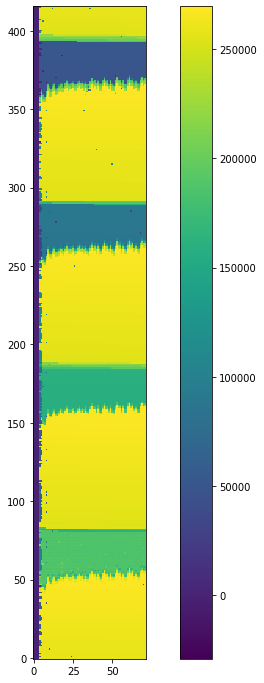

In [10]:
plot_image(output_model.data)

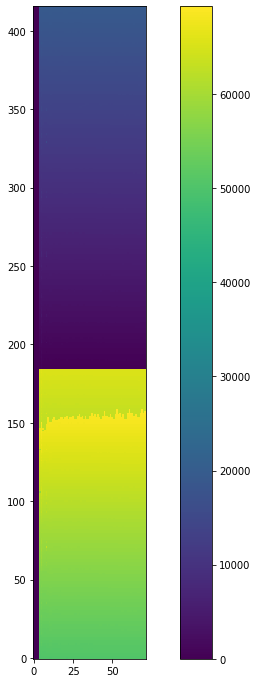

In [11]:
plot_image("test_dark_current.fits", index=(0,0))

***
<a id="pipeline_no_configs"></a>
## Run Pipeline with Parameters Set Programmatically

You can also run the pipeline without relying on configuration files by setting parameters programmatically, and relying on the defaults in the pipeline.   This is the pure-Python alternative to editing .cfg files.

In [12]:
! rm -f test_dark_current.fits   # remove the dark current output,  we'll recreate it another way...

det1p = Detector1Pipeline()
det1p.dark_current.save_results = True
det1p.run("test.fits")

2019-09-11 08:38:41,594 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2019-09-11 08:38:41,596 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2019-09-11 08:38:41,597 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2019-09-11 08:38:41,599 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2019-09-11 08:38:41,601 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2019-09-11 08:38:41,603 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2019-09-11 08:38:41,605 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2019-09-11 08:38:41,607 - stpipe.Detector1Pipeline.rscd - INFO - RSCD_Step instance created.
2019-09-11 08:38:41,609 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2019-09-11 08:38:41,611 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2019-09-11 

2019-09-11 08:38:43,437 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0048.fits
2019-09-11 08:38:43,491 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=6, ngroups=10, nframes=1, groupgap=0
2019-09-11 08:38:43,492 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=1000, nframes=1, groupgap=0
2019-09-11 08:38:43,920 - stpipe.Detector1Pipeline.dark_current - INFO - Saved model in test_dark_current.fits
2019-09-11 08:38:43,920 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2019-09-11 08:38:43,982 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(6, 10, 416, 72) from test_dark_current.fits>,).
2019-09-11 08:38:43,993 - stpipe.Detector1Pipeline.refpix - INFO - use_side_ref_pixels = True
2019-09-11 08:38:43,994 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_columns = True
2019-09-11 08:38:43,994 - stpipe.Detec

<ImageModel(416, 72) from test_dark_current.fits>

Setting save_results=True results in the output of the test_dark_current.fits file which can be passed into the PersistenceStep when run in isolation, next.

In [13]:
! ls test_dark_current.fits   # make sure save_results worked.

test_dark_current.fits


***
<a id="steps_with_config_files"></a>
## Run Individual Steps with Configuration Files

You can also change parameter values in the .cfg files for individual Steps.

Edit the cfgs/persistence.cfg file and change:

```
   input_trapsfilled = ""
   flag_pers_cutoff = 40.
   save_persistence = False
```

to:

```
   input_trapsfilled = ""
   flag_pers_cutoff = 40.
   save_persistence = True
```

This will cause PersistenceStep to output a third output file with suffix “_output_pers”. 

See https://jwst-pipeline.readthedocs.io/en/latest/jwst/persistence/description.html
for more information on the persistence step.

In [20]:
# This cell is pretending to be you creating and editing a new .cfg file.    In real life, you'd edit the file.

! cp cfgs/persistence.cfg  cfgs/persistence_with_out_pers_save.cfg
! perl -pi -e's/save_persistence = False/save_persistence = True/g' cfgs/persistence_with_out_pers_save.cfg
! cat cfgs/persistence_with_out_pers_save.cfg

# And the result is...

name = "persistence"
class = "jwst.persistence.PersistenceStep"

input_trapsfilled = ""
flag_pers_cutoff = 40.
save_persistence = True


In [15]:
from jwst.persistence.persistence_step import PersistenceStep

output_model = PersistenceStep.call("test_dark_current.fits", config_file="cfgs/persistence_with_out_pers_save.cfg")

output_model

2019-09-11 08:39:09,044 - stpipe.persistence - INFO - PersistenceStep instance created.
2019-09-11 08:39:09,124 - stpipe.persistence - INFO - Step persistence running with args ('test_dark_current.fits',).
2019-09-11 08:39:09,352 - stpipe.persistence - WARNING - Missing reference file types:  PERSAT TRAPDENSITY TRAPPARS
2019-09-11 08:39:09,356 - stpipe.persistence - INFO - Step persistence done


<RampModel(6, 10, 416, 72) from test_dark_current.fits>

In [16]:
! ls *.fits    # save_persistence may not be working...

test.fits              test_dark_current.fits


***
<a id="pipelines_level_123"></a>
## Run Level 1, 2, 3, Pipelines in Succession

This section runs the test data through all stages of processing,  chaining the output of each processing level to the input of the next.   Output can optionally be saved to a file.   Alternatively,  in-memory pipeline output can
be passed directly to the next level.

Documentation on all JWST CAL pipelines can be found here: https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/main.html#pipelines

### Run Level 1

Stage 1 consists of detector-level corrections that are performed on a group-by-group basis, followed by ramp fitting. The output of stage 1 processing is a countrate image per exposure, or per integration for some modes. 

In [17]:
output1 = Detector1Pipeline.call("test.fits", config_file="cfgs/calwebb_detector1.cfg")

2019-09-11 08:39:09,550 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2019-09-11 08:39:09,552 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2019-09-11 08:39:09,554 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2019-09-11 08:39:09,555 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2019-09-11 08:39:09,557 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2019-09-11 08:39:09,559 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2019-09-11 08:39:09,560 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2019-09-11 08:39:09,563 - stpipe.Detector1Pipeline.rscd - INFO - RSCD_Step instance created.
2019-09-11 08:39:09,565 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2019-09-11 08:39:09,566 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2019-09-11 

2019-09-11 08:39:11,190 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0048.fits
2019-09-11 08:39:11,242 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=6, ngroups=10, nframes=1, groupgap=0
2019-09-11 08:39:11,243 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=1000, nframes=1, groupgap=0
2019-09-11 08:39:11,446 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2019-09-11 08:39:11,524 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(6, 10, 416, 72) from test.fits>,).
2019-09-11 08:39:11,537 - stpipe.Detector1Pipeline.refpix - INFO - use_side_ref_pixels = True
2019-09-11 08:39:11,538 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_columns = True
2019-09-11 08:39:11,539 - stpipe.Detector1Pipeline.refpix - INFO - side_smoothing_length = 11
2019-09-11 08:39:11,539 - stpipe.Detector1Pipeline.refpix - INFO - s

### Run Level 2

Stage 2 processing consists of additional instrument-level and observing-mode corrections and calibrations to produce fully calibrated exposures. The details differ for imaging and spectroscopic exposures, and there are some corrections that are unique to certain instruments or modes. 

In [18]:
output2 = Image2Pipeline.call(output1, config_file="cfgs/calwebb_image2.cfg")

2019-09-11 08:39:38,555 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.
2019-09-11 08:39:38,557 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2019-09-11 08:39:38,559 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2019-09-11 08:39:38,562 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.
2019-09-11 08:39:38,566 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.
2019-09-11 08:39:38,570 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.
2019-09-11 08:39:38,642 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args (<ImageModel(416, 72) from test.fits>,).
2019-09-11 08:39:38,660 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'test.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslice

2019-09-11 08:39:40,180 - stpipe.Image2Pipeline.resample - INFO - Saved model in test_i2d.fits
2019-09-11 08:39:40,181 - stpipe.Image2Pipeline.resample - INFO - Step resample done
2019-09-11 08:39:40,181 - stpipe.Image2Pipeline - INFO - Finished processing product test
2019-09-11 08:39:40,183 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2
2019-09-11 08:39:40,508 - stpipe.Image2Pipeline - INFO - Saved model in test_cal.fits
2019-09-11 08:39:40,509 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


### Run Level 3

Stage 3 processing consists of routines that work with multiple exposures and in most cases produce some kind of combined product. There are unique pipeline modules for stage 3 processing of imaging, spectroscopic, coronagraphic, AMI, and TSO observations.

In [19]:
output3 = Image3Pipeline.call(output2[0], config_file="cfgs/calwebb_image3.cfg")

2019-09-11 08:39:40,524 - stpipe.Image3Pipeline - INFO - Image3Pipeline instance created.
2019-09-11 08:39:40,526 - stpipe.Image3Pipeline.tweakreg - INFO - TweakRegStep instance created.
2019-09-11 08:39:40,528 - stpipe.Image3Pipeline.skymatch - INFO - SkyMatchStep instance created.
2019-09-11 08:39:40,530 - stpipe.Image3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.
2019-09-11 08:39:40,532 - stpipe.Image3Pipeline.resample - INFO - ResampleStep instance created.
2019-09-11 08:39:40,534 - stpipe.Image3Pipeline.source_catalog - INFO - SourceCatalogStep instance created.
2019-09-11 08:39:40,602 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline running with args (<ImageModel(416, 72) from test_cal.fits>,).
2019-09-11 08:39:40,616 - stpipe.Image3Pipeline - INFO - Prefetching reference files for dataset: 'test_cal.fits' reftypes = ['drizpars']
2019-09-11 08:39:40,621 - stpipe.Image3Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/refer